# Potato_disease_classification

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [2]:
# define constant for model
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Dataset preprocessing

In [3]:
# import data into tensorflow dataset object
# we need this b/z if we input all images to model it will take more time and very slow
# so we make batches of images and pass it

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\DataSetfor MLandDL\potat_disease_classification\PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# it give you 1 batch if passed 1 and if passed 2 it give 2 batch 
# train_dataset.take(1)
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


# visualize some images from our dataset 

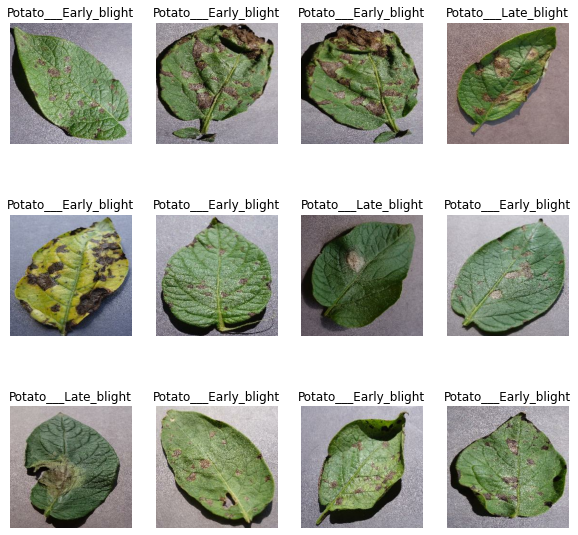

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# split the dataset into train ,validate and test
# train dataset--> are those data at which we train our model(learn feature)
# validation dataset ---> are those data to test our model durning training(we say that our model has 85% accuracy this accuracy due to validatation dataset)
# test dataset ---> to test our model that it currently working or not (classification or not)


In [13]:
len(dataset)

68

In [ ]:
68*32



In [ ]:
# 68 ---> means we have 68 batch --->b/z we divide the dataset into batches

In [14]:
train_size = 0.8
len(dataset ) * train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

(<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [22]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


# Cache , shuffle and prefetch dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building model

###  creating a layers for resizing and Normalization

In [24]:
# before we feed our images to network we should resize it into desired size .
# Moreover it impore model performance , we should normalized the image pixel value(keeping them in range 0-1 by % 255)
# Normalization should happen both in training and in inference. we can add that as a layer in our sequential model 

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [26]:
# data augmentation is need when you have less amount of data, with the help of data augmentation you boost your model 
# accuracy
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Apply Data Augmentation on Trianing dataset

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


######   Model Architecture

In [93]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [94]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [95]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [96]:
model.fit(train_ds, batch_size=BATCH_SIZE, epochs=10, verbose=1, validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 74s 1s/step - loss: 0.9257 - accuracy: 0.4676 - val_loss: 0.9557 - val_accuracy: 0.4792
Epoch 2/10
54/54 [==============================] - 69s 1s/step - loss: 0.7238 - accuracy: 0.6638 - val_loss: 0.6197 - val_accuracy: 0.6979
Epoch 3/10
54/54 [==============================] - 67s 1s/step - loss: 0.6138 - accuracy: 0.7350 - val_loss: 0.5572 - val_accuracy: 0.7656
Epoch 4/10
54/54 [==============================] - 70s 1s/step - loss: 0.4378 - accuracy: 0.8177 - val_loss: 0.4260 - val_accuracy: 0.8021
Epoch 5/10
54/54 [==============================] - 73s 1s/step - loss: 0.3564 - accuracy: 0.8449 - val_loss: 0.4747 - val_accuracy: 0.7865
Epoch 6/10
54/54 [==============================] - 72s 1s/step - loss: 0.2760 - accuracy: 0.8912 - val_loss: 1.2038 - val_accuracy: 0.6875
Epoch 7/10
54/54 [==============================] - 72s 1s/step - loss: 0.2548 - accuracy: 0.9062 - val_loss: 0.7063 - val_accuracy: 0.7344
Epoch 8/10
54/54 [==

In [98]:
result_on_test_data = model.evaluate(test_ds)

8/8 [==============================] - 1s 183ms/step - loss: 0.2284 - accuracy: 0.9138


### Run prediction on a sample images


first image to predict
actual class label:  Potato___Early_blight
1/1 [==============================] - 0s 470ms/step
predicted class label: Potato___Early_blight


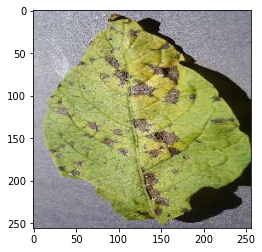

In [99]:
import numpy as np

for images_batch, label_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_image_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual class label: ", class_names[first_image_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted class label:", class_names[np.argmax(batch_prediction[0])])
#     print("predicted class label:",class_names[np.argmax(batch_prediction[0])]  )

### after that we write a function for inference

In [100]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    predicted_class_label = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    
    return predicted_class_label,confidence

32
1/1 [==============================] - 0s 26ms/step


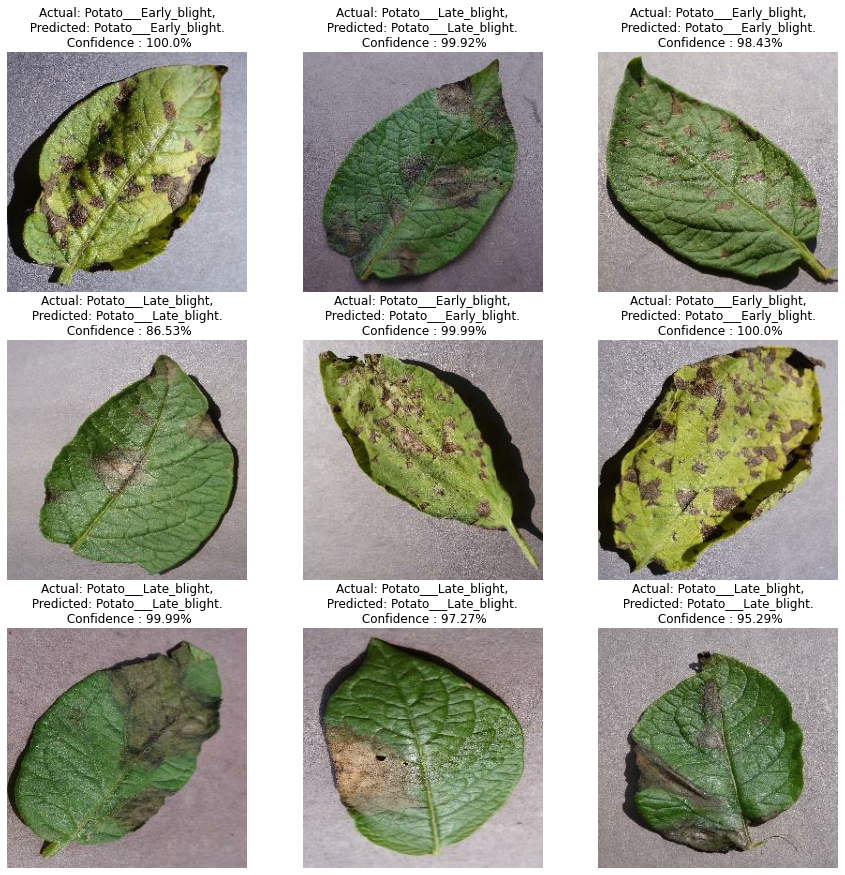

In [102]:
plt.figure(figsize=(15,15))
for images, label in test_ds.take(1):
    print(len(images))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class_label,confidence = predict(model, images[i].numpy())
        actual_class = class_names[label[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class_label}. \n Confidence : {confidence}%")
        plt.axis('off')

In [103]:
# I want to save my model
# b/z if need to change some things we can easly take the model and apply those changes
# and again save this to another version

In [126]:
# next time when i do some changes to my model it will save automatically and increment model version
import os
My_model_version = max([int(i) for i in os.listdir("./My_model_version")+ [0]])+1
model.save(f"./My_model_version/{My_model_version}")

INFO:tensorflow:Assets written to: ./My_model_version/2\assets


INFO:tensorflow:Assets written to: ./My_model_version/2\assets
